In [1]:
!mkdir ./dataset

In [ ]:
!unzip data.zip -d ./dataset

# Import Libraries

In [3]:
import os
import cv2
from PIL import Image
import shutil
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Data Preprocessing

In [77]:
def preprocess_images(data_dir, image_size = (28, 28)):
  images = []
  labels = []

  for char_dir in os.listdir(data_dir):
    char_path = os.path.join(data_dir, char_dir)

    if os.path.isdir(char_path):
      for image_name in os.listdir(char_path):
        image_path = os.path.join(char_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size)

        h, w = image.shape[:2]
        aspect_ratio = w / h

        if aspect_ratio > 1:
          new_w = image_size[1]
          new_h = int(new_w / aspect_ratio)
        else:
          new_h = image_size[0]
          new_w = int(new_h * aspect_ratio)

        image_resized = cv2.resize(image, (new_w, new_h))

        delta_w = image_size[1] - new_w
        delta_h = image_size[0] - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        image_padded = cv2.copyMakeBorder(image_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value = [0, 0, 0])

        images.append(image_padded)
        labels.append(char_dir)

  return np.array(images), np.array(labels)

In [78]:
data_dir = './dataset/data'

In [79]:
images, labels = preprocess_images(data_dir)

In [80]:
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

Images shape: (310, 28, 28, 3)
Labels shape: (310,)


In [81]:
classification_labels = np.unique(labels)
label_encoder = LabelEncoder()
label_encoder.fit(classification_labels)
labels = label_encoder.transform(labels)

In [82]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [83]:
print("Label Mapping:", label_mapping)

Label Mapping: {'baymax': 0, 'cinderella': 1, 'elsa': 2, 'joy': 3, 'judy': 4, 'moana': 5, 'mulan': 6, 'mushu': 7, 'olaf': 8, 'pooh': 9, 'rapunzel': 10, 'walle': 11}


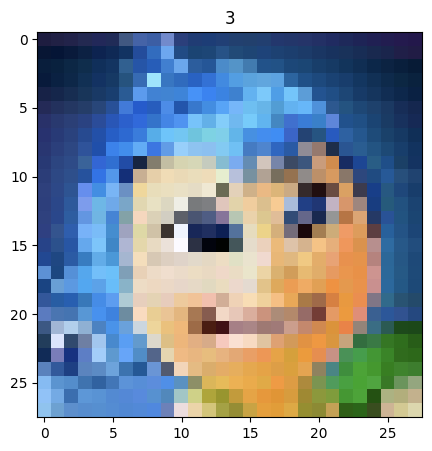

In [84]:
plt.figure(figsize = (5, 5))
plt.imshow(images[233])
plt.title(labels[233])
plt.show()

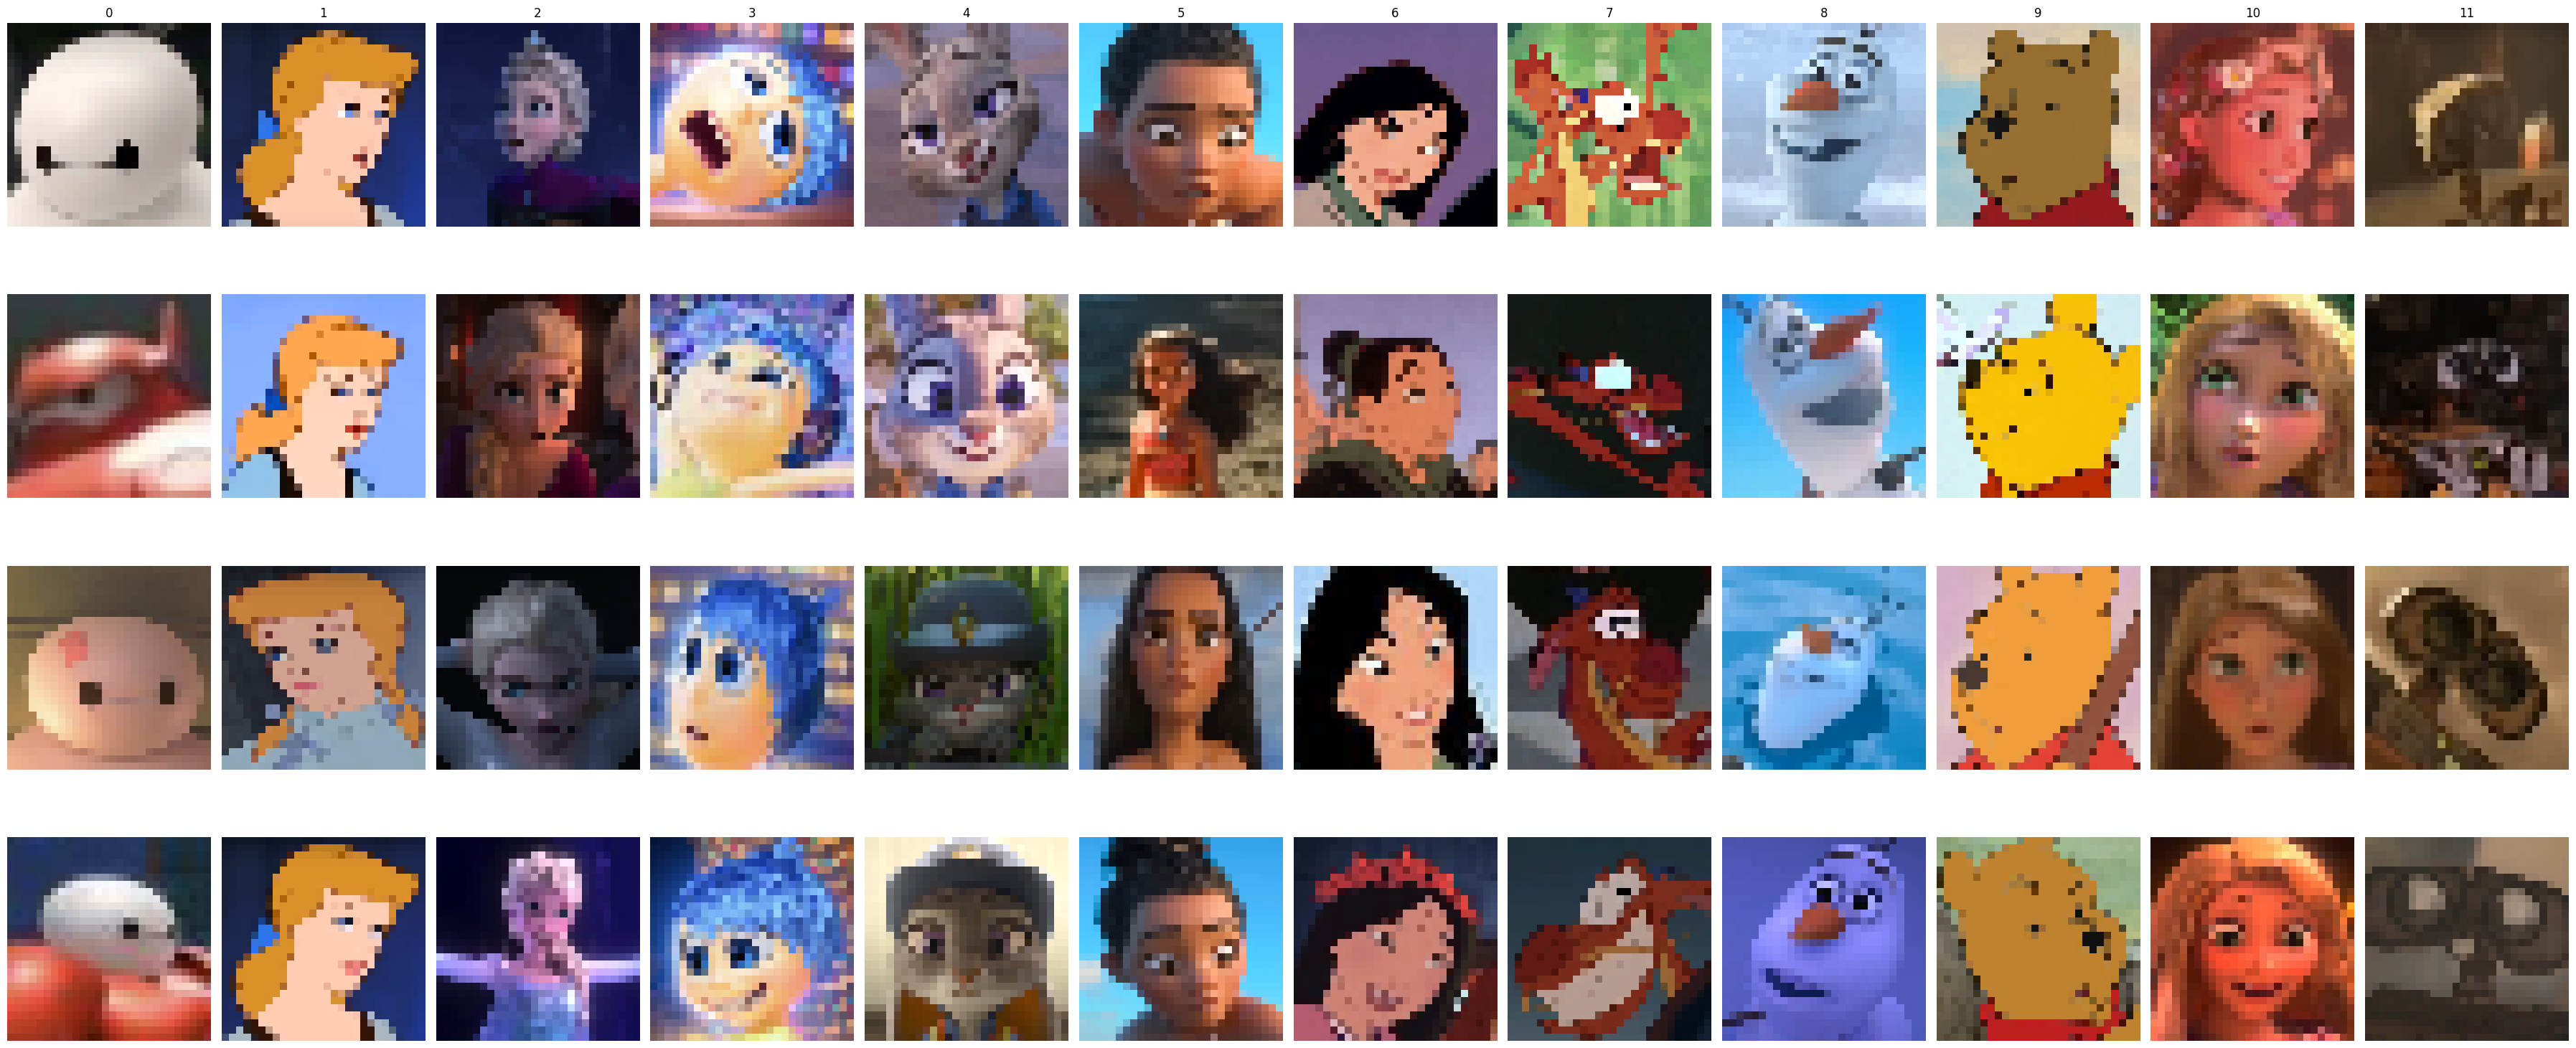

In [85]:
def plot_characters_stacked(data_dir, images, labels):
    unique_labels = list(set(labels))
    selected_images = {label: [] for label in unique_labels}

    for label in unique_labels:
        indices = [i for i, lbl in enumerate(labels) if lbl == label]
        selected_images[label].append(images[indices[16]])
        selected_images[label].append(images[indices[17]])
        selected_images[label].append(images[indices[18]])
        selected_images[label].append(images[indices[22]])

    num_rows = len(selected_images[next(iter(selected_images))])
    num_columns = len(unique_labels)

    plt.figure(figsize=(num_columns * 3, num_rows * 4))
    for j in range(num_rows):
        for i, label in enumerate(unique_labels):
            if j < len(selected_images[label]):
                plt.subplot(num_rows, num_columns, j * num_columns + i + 1)
                plt.imshow(selected_images[label][j])
                plt.title(label if j == 0 else '')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_characters_stacked(data_dir, images, labels)

## Training/Test Split

In [86]:
# Shuffle data and train/test/split
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2, shuffle = True, random_state = 42, stratify = labels)

# Baseline

In [87]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam

In [88]:
def SimpleCNN(input_shape, num_classes):
  inputs = Input(input_shape)

  x = Conv2D(32, (3, 3), activation = 'relu')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3), activation = 'relu')(x)
  x= MaxPooling2D((2, 2))(x)
  x = Flatten()(x)
  x = Dense(64, activation = 'relu')(x)
  outputs = Dense(num_classes, activation = 'softmax')(x)

  model = Model(inputs, outputs)

  return model

In [89]:
num_classes = len(np.unique(labels))
num_classes

12

In [95]:
cnn_model = SimpleCNN((28, 28, 3), num_classes)
cnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,636 (479.05 KB)

 Trainable params: 122,636 (479.05 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
cnn_model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [97]:
history = cnn_model.fit(train_images, train_labels, validation_data=(test_images, test_labels), batch_size = 16, epochs = 40)

Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.0986 - loss: 46.2514 - val_accuracy: 0.1774 - val_loss: 9.3039
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2581 - loss: 6.3915 - val_accuracy: 0.3548 - val_loss: 3.8750
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3825 - loss: 2.3862 - val_accuracy: 0.5161 - val_loss: 2.5866
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6279 - loss: 1.3949 - val_accuracy: 0.4677 - val_loss: 2.3718
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6316 - loss: 1.2106 - val_accuracy: 0.5645 - val_loss: 2.0324
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7256 - loss: 0.9974 - val_accuracy: 0.5968 - val_loss: 1.6685
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8841 - loss: 0.3676 - val_accuracy: 0.6935 - val_loss: 1.3499
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9349 - loss: 0.2808 - val_accuracy: 0.6935 - val_lo

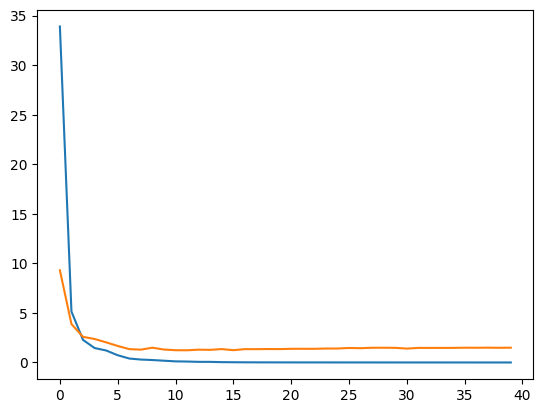

In [98]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")

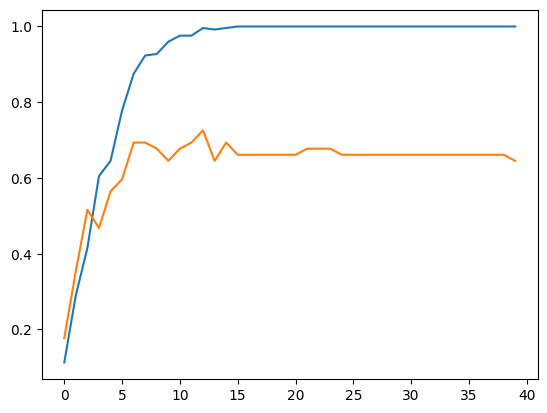

In [99]:
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")

In [100]:
predictions = cnn_model.predict(test_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step


In [104]:
predicted_labels = np.argmax(predictions, axis = 1)

In [105]:
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
print("Classification accuracy:", accuracy)
print("Classification precision:", precision)
print("Classification recall:", recall)

Classification accuracy: 0.6451612903225806
Classification precision: 0.6955645161290323
Classification recall: 0.6451612903225806


In [106]:
predicted_train = cnn_model.predict(train_images)
predicted_train_labels = np.argmax(predicted_train, axis = 1)

accuracy_train = accuracy_score(train_labels, predicted_train_labels)
precision_train = precision_score(train_labels, predicted_train_labels, average='weighted')
recall_train = recall_score(train_labels, predicted_train_labels, average='weighted')

print("Classification accuracy:", accuracy_train)
print("Classification precision:", precision_train)
print("Classification recall:", recall_train)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
Classification accuracy: 1.0
Classification precision: 1.0
Classification recall: 1.0


# Simaese CNN

In [14]:
def build_siamese_model(input_shape, embedding_size=64):

  base_resnet = ResNet50(weights="imagenet", input_shape = (32, 32, 3), include_top=False)

  for layer in base_resnet.layers[:-10]:
    layer.trainable = False

  input = Input(shape = input_shape)
  x = base_resnet(input, training=False)

  x = GlobalAveragePooling2D()(x)
  x = Dense(embedding_size, activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)

  output = Dense(embedding_size, activation = 'relu')(x)

  return Model(input, output)

In [23]:
@keras.saving.register_keras_serializable()
def euclidean_distance(vectors):
	(featsA, featsB) = vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)

	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [16]:
def make_pairs(images, labels):

    """
      This function creates positive and negative pairs of images
      from our disney character recognition dataset.
    """
    pairImages = []
    pairLabels = []

    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    for idxA in range(len(images)):

      currentImage = images[idxA]
      label = labels[idxA]

      idxB = np.random.choice(idx[label])
      posImage = images[idxB]

      # positive pairs have a label 1
      pairImages.append([currentImage, posImage])
      pairLabels.append([1])

      negIdx = np.where(labels != label)[0]
      negImage = images[np.random.choice(negIdx)]

      # negative paris have a label 0
      pairImages.append([currentImage, negImage])
      pairLabels.append([0])

    return [np.array(pairImages), np.array(pairLabels)]

In [17]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2, shuffle=True, random_state = 42, stratify=labels)

In [18]:
print("Train set class distribution:", dict(zip(*np.unique(train_labels, return_counts=True))))
print("Test set class distribution:", dict(zip(*np.unique(test_labels, return_counts=True))))

Train set class distribution: {0: 22, 1: 20, 2: 22, 3: 20, 4: 21, 5: 22, 6: 20, 7: 20, 8: 20, 9: 20, 10: 21, 11: 20}
Test set class distribution: {0: 5, 1: 5, 2: 6, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 6, 11: 5}


In [19]:
img_shape = (32,32,3)
batch_size = 64
epochs = 100
model_path = "simaese_model_resnet.keras"
plot_path = "training_plot.png"

In [41]:
[pairTrain, labelTrain] = make_pairs(train_images, train_labels)
[pairTest, labelTest] = make_pairs(test_images, test_labels)

In [42]:
# Shuffle training data
train_indices = np.arange(len(pairTrain))
np.random.shuffle(train_indices)
pairTrain = pairTrain[train_indices]
labelTrain = labelTrain[train_indices]

# Shuffle testing data
test_indices = np.arange(len(pairTest))
np.random.shuffle(test_indices)
pairTest = pairTest[test_indices]
labelTest = labelTest[test_indices]

In [43]:
pairTrain[0].shape, labelTrain[0].shape

((2, 32, 32, 3), (1,))

In [ ]:
# pairTrain[0][0]

In [ ]:
# pairTrain[0][1]

In [ ]:
# labelTrain[0]

In [ ]:
# pairTrain[1][0]

In [ ]:
# pairTrain[1][1]

In [ ]:
# labelTrain[1]

In [ ]:
imgA = Input(shape=img_shape)
imgB = Input(shape=img_shape)

featureExtractor = build_siamese_model(img_shape)

featureA = featureExtractor(imgA)
featureB = featureExtractor(imgB)

distance = Lambda(euclidean_distance)([featureA, featureB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [ ]:
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]],
  labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=batch_size,
	epochs=epochs)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.4834 - loss: 1.6942 - val_accuracy: 0.5887 - val_loss: 2.3460
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.5312 - loss: 1.1264 - val_accuracy: 0.5887 - val_loss: 2.1594
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5054 - loss: 1.0253 - val_accuracy: 0.5887 - val_loss: 1.5369
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5175 - loss: 0.9164 - val_accuracy: 0.5887 - val_loss: 1.0545
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5063 - loss: 0.8738 - val_accuracy: 0.5887 - val_loss: 0.8364
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5044 - loss: 0.8210 - val_accuracy: 0.5887 - val_loss: 0.7414
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4408 - loss: 0.8703 - val_accuracy: 0.6048 - val_loss: 0.7058
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4934 - loss: 0.7954 - val_accuracy: 0.5887 - val_loss:

In [ ]:
model.save(model_path)

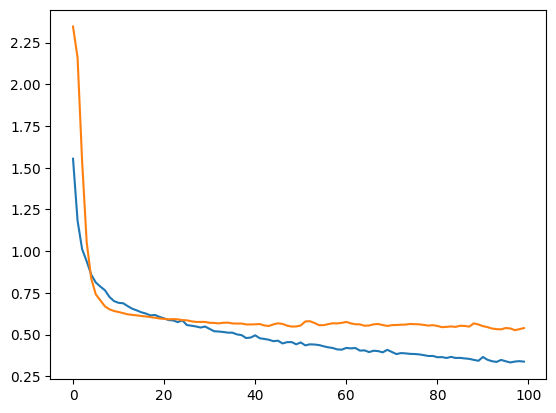

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")

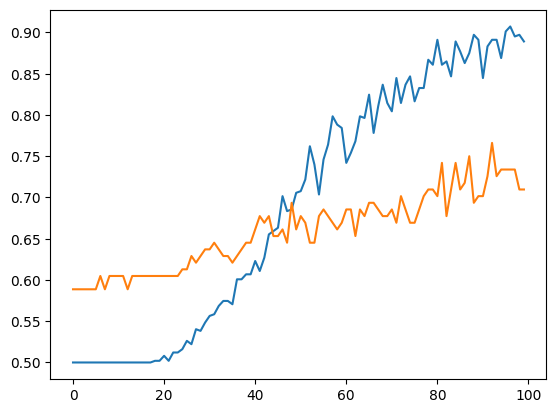

In [ ]:
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")

In [ ]:
model.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 963ms/step - accuracy: 0.7151 - loss: 0.5548


[0.5395559668540955, 0.7096773982048035]

# Inferencing and Evaluation

In [70]:
import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [24]:
model = keras.models.load_model(model_path)

In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_22            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 64)             │     23,723,264 │ input_layer_21[0][0],  │
│                           │                        │                │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ functional[0][0],      │
│                           │                        │                │ functional[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │              2 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,925,448 (125.60 MB)

 Trainable params: 4,601,090 (17.55 MB)

 Non-trainable params: 19,122,176 (72.95 MB)

 Optimizer params: 9,202,182 (35.10 MB)

In [26]:
import tensorflow as tf

def predict_similarity(model, image1, image2):

    img1 = np.expand_dims(image1, axis=0)
    img2 = np.expand_dims(image2, axis=0)

    similarity_score = model.predict([img1, img2])[0][0]

    return similarity_score


In [27]:
def get_classification(image, image_referencess):
  similarity_score = []

  for image_reference in image_referencess:
    similarity_score.append(predict_similarity(model, image, image_reference))

  return np.argmax(similarity_score)

In [28]:
reference_images = {}

for img, label in zip(images, labels):
    if label not in reference_images:
        reference_images[label] = img

reference_images = dict(sorted(reference_images.items()))

In [33]:
get_classification(images[4], list(reference_images.values()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


0

array([[[ 91,  82,  78],
        [ 92,  84,  79],
        [ 65,  65,  58],
        ...,
        [ 17,  20,  19],
        [ 20,  23,  22],
        [ 19,  22,  21]],

       [[ 93,  84,  80],
        [ 93,  84,  80],
        [ 44,  43,  36],
        ...,
        [ 16,  19,  18],
        [ 16,  19,  18],
        [ 16,  19,  18]],

       [[ 91,  85,  80],
        [ 65,  60,  54],
        [ 54,  52,  45],
        ...,
        [ 18,  18,  18],
        [ 18,  18,  18],
        [ 17,  17,  17]],

       ...,

       [[ 18,  18,  18],
        [ 19,  18,  17],
        [ 28,  25,  23],
        ...,
        [187, 179, 171],
        [191, 182, 174],
        [188, 180, 172]],

       [[ 59,  59,  59],
        [ 60,  59,  58],
        [138, 135, 133],
        ...,
        [191, 182, 174],
        [193, 184, 176],
        [191, 183, 175]],

       [[ 62,  59,  56],
        [196, 191, 186],
        [215, 206, 198],
        ...,
        [189, 180, 172],
        [189, 180, 172],
        [190, 182, 174]]], dtype=uint8)
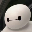

In [34]:
images[4]

In [35]:
get_classification(images[30], list(reference_images.values()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


0

array([[[148, 173, 133],
        [148, 173, 133],
        [148, 173, 133],
        ...,
        [147, 169, 128],
        [147, 169, 128],
        [147, 169, 127]],

       [[148, 173, 133],
        [148, 173, 133],
        [149, 173, 135],
        ...,
        [148, 170, 129],
        [146, 170, 128],
        [146, 168, 126]],

       [[148, 173, 133],
        [147, 175, 132],
        [150, 178, 134],
        ...,
        [151, 170, 130],
        [148, 168, 128],
        [146, 167, 127]],

       ...,

       [[156, 182, 134],
        [150, 179, 130],
        [152, 176, 129],
        ...,
        [160, 177, 129],
        [153, 170, 125],
        [153, 170, 125]],

       [[155, 181, 132],
        [155, 182, 132],
        [153, 176, 128],
        ...,
        [160, 178, 130],
        [153, 170, 125],
        [152, 171, 125]],

       [[154, 184, 138],
        [153, 180, 130],
        [155, 175, 129],
        ...,
        [160, 180, 131],
        [154, 172, 127],
        [152, 171, 125]]], dtype=uint8)
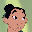

In [36]:
images[30]

In [29]:
%%capture

y_pred = [get_classification(img, reference_images.values()) for img in images]

In [52]:
y_pred = np.array(y_pred)
np.unique(y_pred, return_counts=True)

(array([ 0,  1,  3,  4,  5,  7,  8,  9, 10, 11]),
 array([87, 33, 24, 12, 24, 24, 22, 23, 41, 20]))

In [66]:
y_pred_decoded = label_encoder.inverse_transform(y_pred)
class_labels, prediction_count = np.unique(y_pred_decoded, return_counts=True)

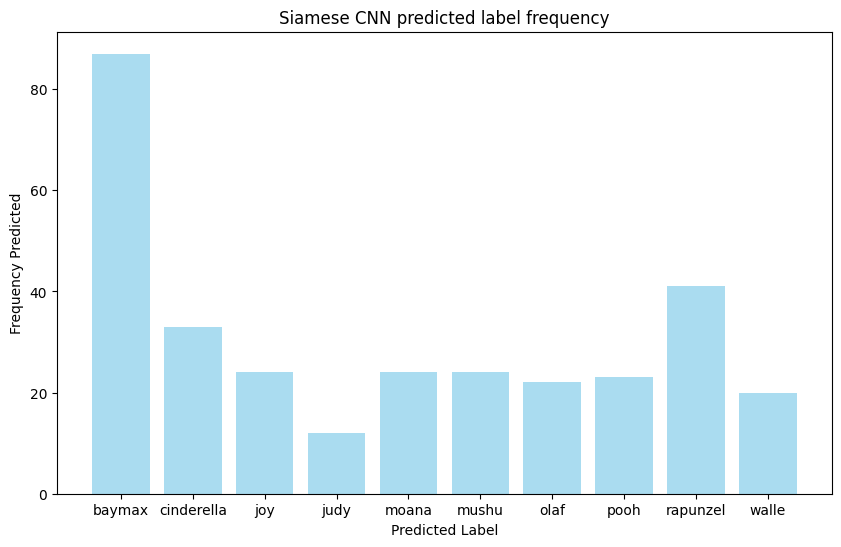

In [69]:
# prompt: make histogram plot

plt.figure(figsize=(10, 6))
plt.bar(class_labels, prediction_count, color='skyblue', alpha=0.7)
plt.xlabel('Predicted Label')
plt.ylabel('Frequency Predicted')
plt.title('Siamese CNN predicted label frequency')
plt.show()

In [73]:
# Classification Accuracy
accuracy = accuracy_score(labels, y_pred)
precision = precision_score(labels, y_pred, average='weighted')
recall = recall_score(labels, y_pred, average='weighted')
print("Siamese Classification accuracy:", accuracy)
print("Siamese Classification precision:", precision)
print("Siamese Classification recall:", recall)

Siamese Classification accuracy: 0.6129032258064516
Siamese Classification precision: 0.5815838075526288
Siamese Classification recall: 0.6129032258064516


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
# Similarity Accuracy
similarity_scores = model.predict([pairTest[:, 0], pairTest[:, 1]])
similarity_labels = (similarity_scores > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [74]:
similarity_accuracy = accuracy_score(labelTest, similarity_labels)
precision = precision_score(labelTest, similarity_labels, average='weighted')
recall = recall_score(labelTest, similarity_labels, average='weighted')

print("Similarity accuracy:", similarity_accuracy)
print("Similarity precision:", precision)
print("Similarity recall:", recall)

Similarity accuracy: 0.6774193548387096
Similarity precision: 0.7086903304773562
Similarity recall: 0.6774193548387096


In [55]:
similarity_scores_train = model.predict([pairTrain[:, 0], pairTrain[:, 1]])
similarity_labels_train = (similarity_scores_train > 0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 553ms/step


In [76]:
similarity_accuracy_train = accuracy_score(labelTrain, similarity_labels_train)
similarity_precision_train = precision_score(labelTrain, similarity_labels_train, average='weighted')
similarity_recall_train = recall_score(labelTrain, similarity_labels_train, average='weighted')

print("Similarity accuracy:", similarity_accuracy_train)
print("Similarity precision:", similarity_precision_train)
print("Similarity recall:", similarity_recall_train)

Similarity accuracy: 0.8608870967741935
Similarity precision: 0.8618814706122117
Similarity recall: 0.8608870967741935
